## Imports and utils

### Imports

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

from scipy import stats
from boruta  import BorutaPy

import matplotlib.pyplot as plt
from IPython.core.display import HTML 

from category_encoders import OneHotEncoder

from xgboost  import XGBClassifier
# from lightgbm import LGBMClassifier

from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm          import SVC


# import inflection
seed = 69
np.random.seed(seed)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing   import MinMaxScaler
from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score

### Utils

In [5]:
def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    
    sns.set(font_scale=1.6)
    
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
jupyter_settings()

In [6]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [70]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, 
                        index=[model_name])

In [71]:
def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []
    
    mm = MinMaxScaler()
    
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    count = 0
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))
    
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)
    
        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))
        
        
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

## Data Analysis

### Load Data

In [7]:
data = pd.read_csv('Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


### Columns

#### Description

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### Data dimensions

In [9]:
print('Number of Rows: {}'.format(data.shape[0]))
print('Number of Cols: {}'.format(data.shape[1]))

Number of Rows: 6362620
Number of Cols: 11


### Dtype 

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### check NA

In [11]:
data.isna().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

There are no NA values

### Descriptive Statistics

In [12]:
data.isFlaggedFraud = data.isFlaggedFraud.map({1:'yes', 0:'no'})
data.isFraud = data.isFraud.map({1:'yes', 0:'no'})

In [13]:
num_attributes = data.select_dtypes(exclude='object')
cat_attributes = data.select_dtypes(include="object")


#### Categorical attributes

In [14]:
cat_attributes.describe()

,type,nameOrig,nameDest,isFraud,isFlaggedFraud
count,6362620,6362620,6362620,6362620,6362620
unique,5,6353307,2722362,2,2
top,CASH_OUT,C1902386530,C1286084959,no,no
freq,2237500,3,113,6354407,6362604


In [15]:
print(np.unique(cat_attributes.isFlaggedFraud, return_counts=True))
print(np.unique(cat_attributes.isFraud, return_counts=True))

(array(['no', 'yes'], dtype=object), array([6362604,      16]))
(array(['no', 'yes'], dtype=object), array([6354407,    8213]))


- most common type (almost one third) of transaction is CASH OUT.

- nameOrg and nameDest have high cardinality. Hence we cant use onehot encoding for these.

- there are more fraud than flaggedfraud, hence current system doesnt recognize fraud cases efficeiently. (only 16 of 8213 cases have been flagged)


#### Numerical attributes

In [16]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

In [17]:
describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02,7.420000e+02,0.584772,0.375177,0.329071
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07,9.244552e+07,3.357344,30.993949,1797.956705
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07,5.958504e+07,3.463606,5.249136,32.964879
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07,4.958504e+07,3.419485,5.176884,32.066985
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08,3.560159e+08,3.088194,19.921758,948.674125
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08,3.561793e+08,2.999298,19.352302,862.156508


## Feature Engineering

In [18]:
df2 = data.copy()

In [19]:
df2.head(35)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,no,no
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,no,no
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,yes,no
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,yes,no
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,no,no
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,no,no
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,no,no
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,no,no
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,no,no
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,no,no


In [20]:
# step
df2['step_days'] = df2['step'].apply(lambda i: i/24)
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
df2['diff_new_old_balance'] = df2['newbalanceOrig'] - df2['oldbalanceOrg']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df2['diff_new_old_destination'] = df2['newbalanceDest'] - df2['oldbalanceDest']

# name orig and name dest
df2['nameOrig'] = df2['nameOrig'].apply(lambda i: i[0])
df2['nameDest'] = df2['nameDest'].apply(lambda i: i[0])

In [21]:
df2[['nameOrig', 'nameDest']].describe()

,nameOrig,nameDest
count,6362620,6362620
unique,1,2
top,C,C
freq,6362620,4211125


## Exploratory Data Analysis

In [22]:
df3 = df2.copy()

### label

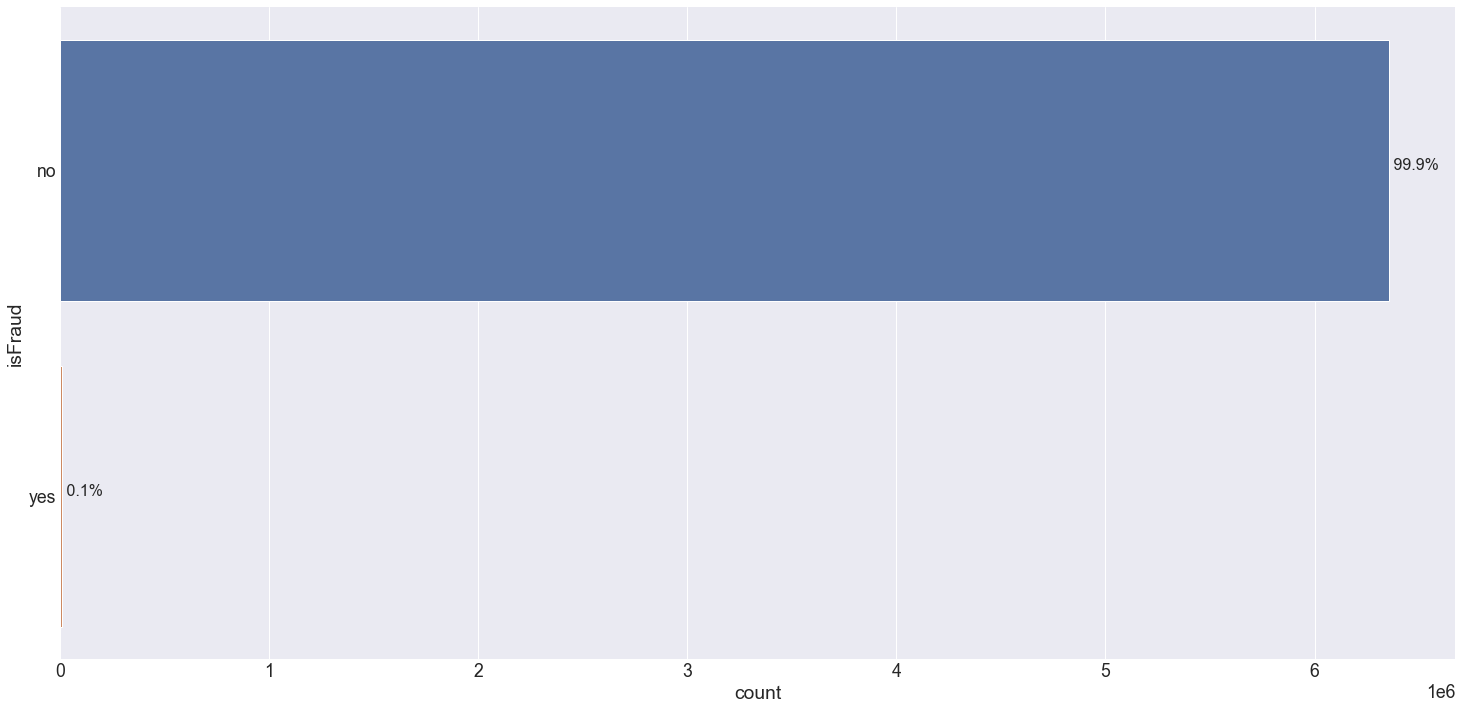

In [23]:
ax = sns.countplot(y='isFraud', data=df3)
total = df3['isFraud'].size
for p in ax.patches:
    # print(p)
    percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

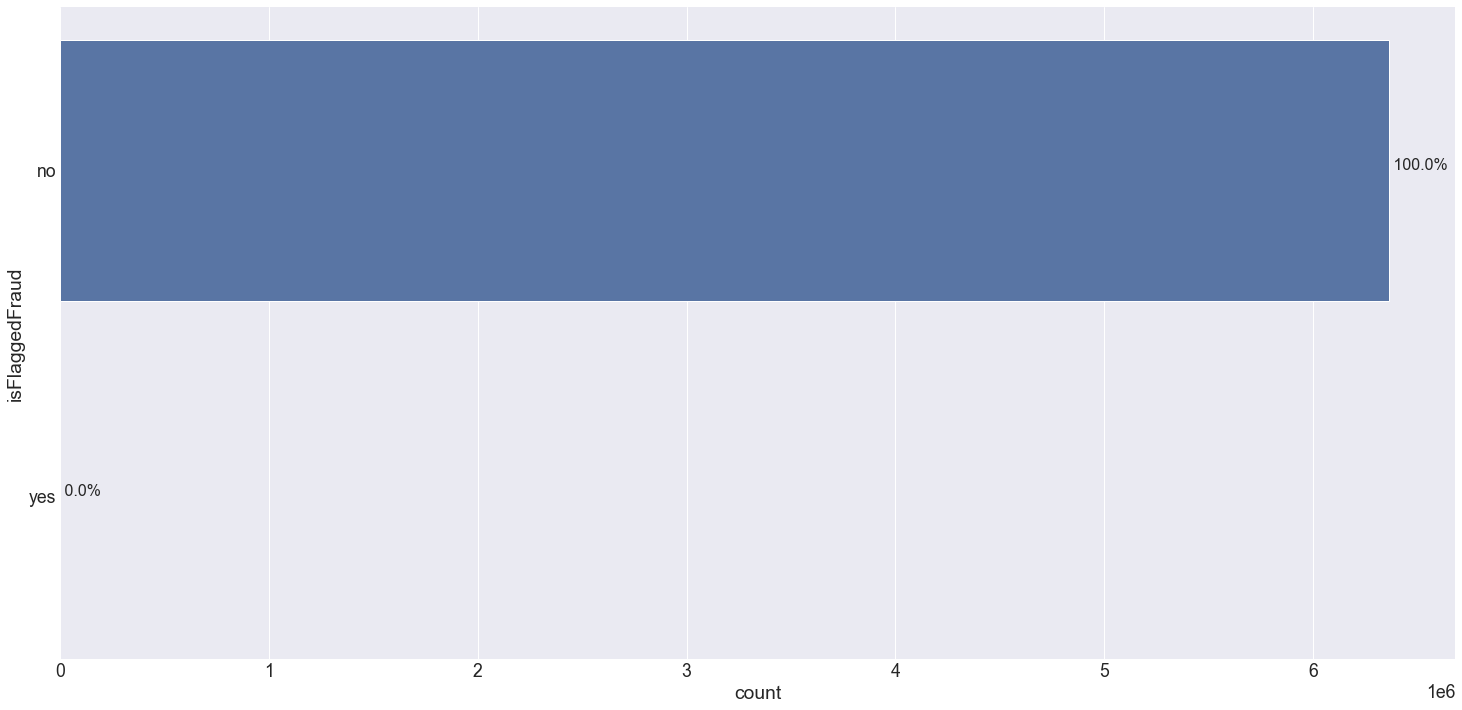

In [24]:
ax = sns.countplot(y='isFlaggedFraud', data=df3)
total = df3['isFlaggedFraud'].size
for p in ax.patches:
    # print(p)
    percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

### numerical attributes

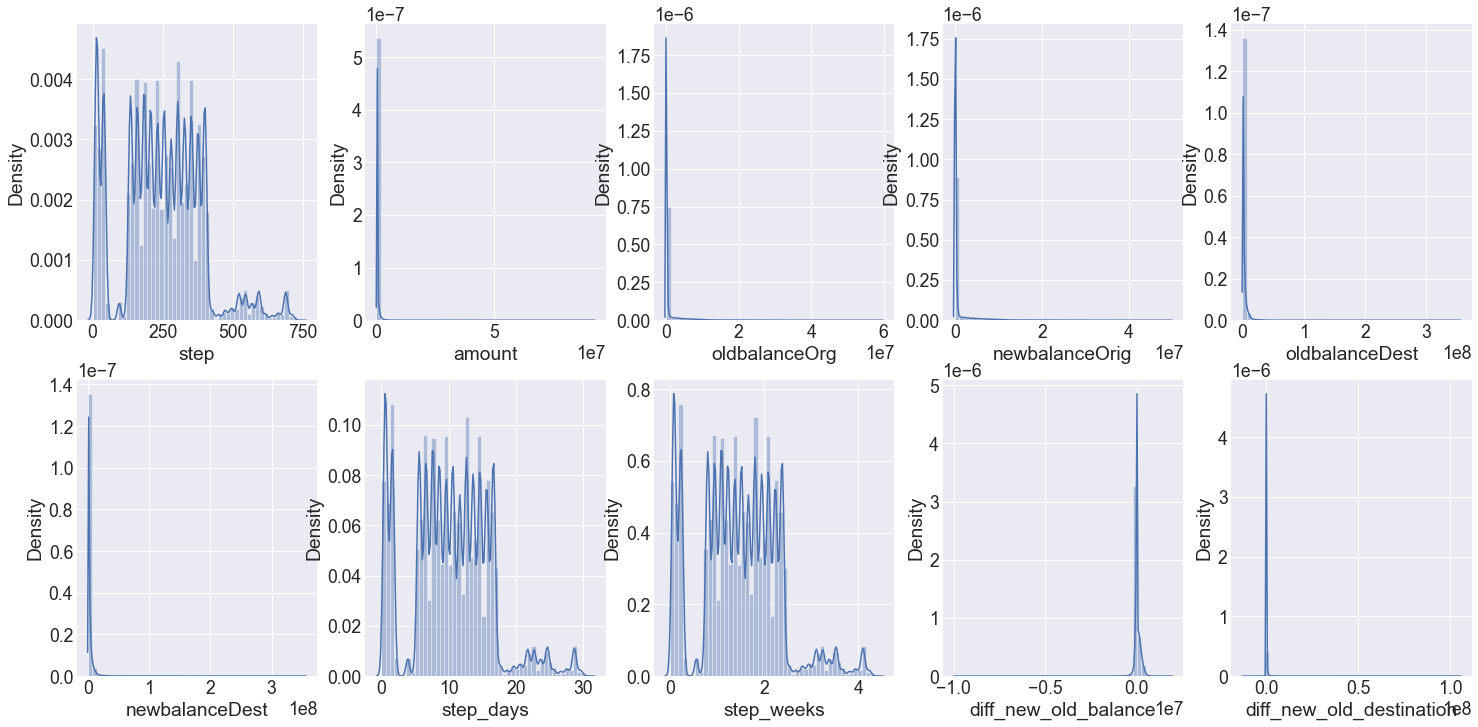

In [25]:
num_attributes = df3.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 5, j)
    sns.distplot(num_attributes[column])
    
    j += 1

### categorical attributes

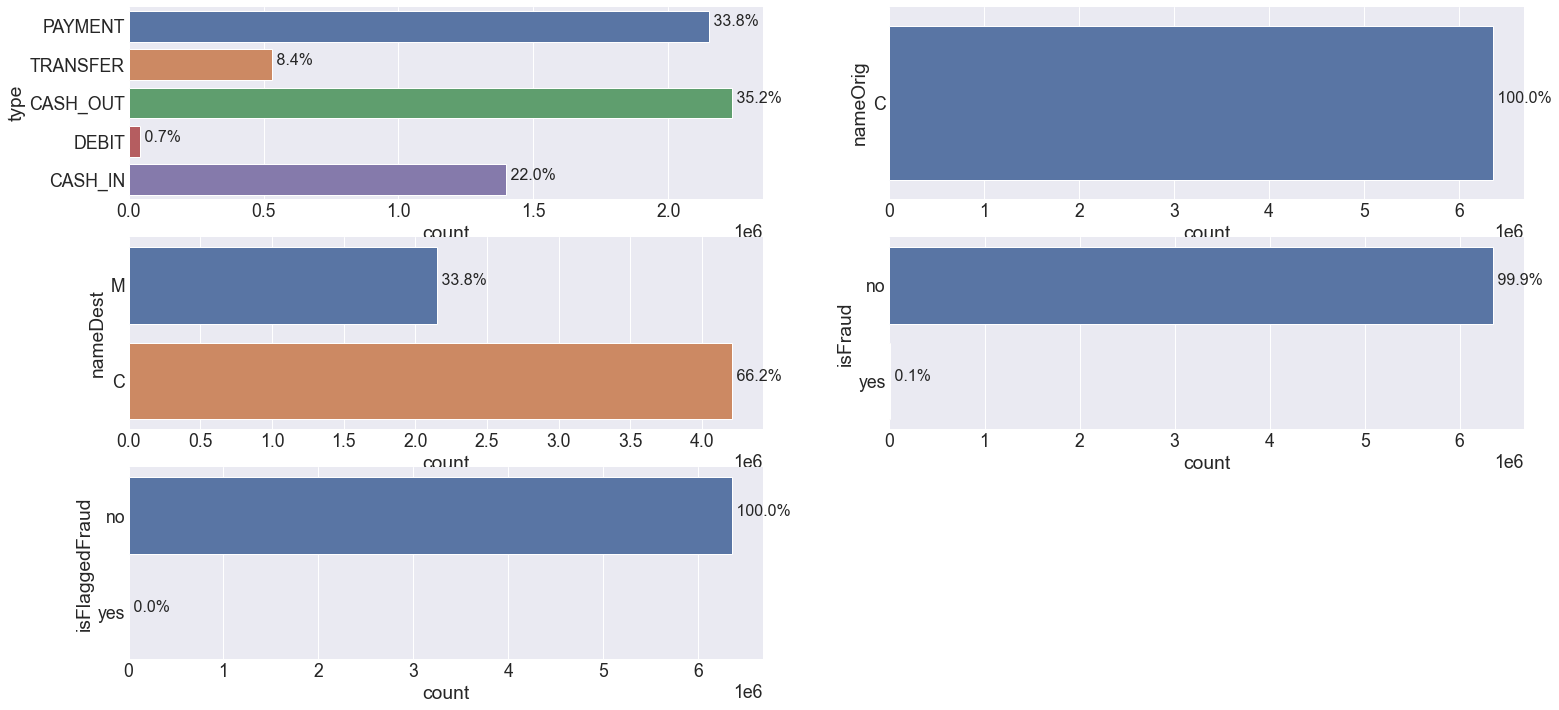

In [26]:
cat_attributes = df3.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        # print(p)
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

#### all frauds occur with customer destinations, no merchants are frauds?

array(['C'], dtype=object)

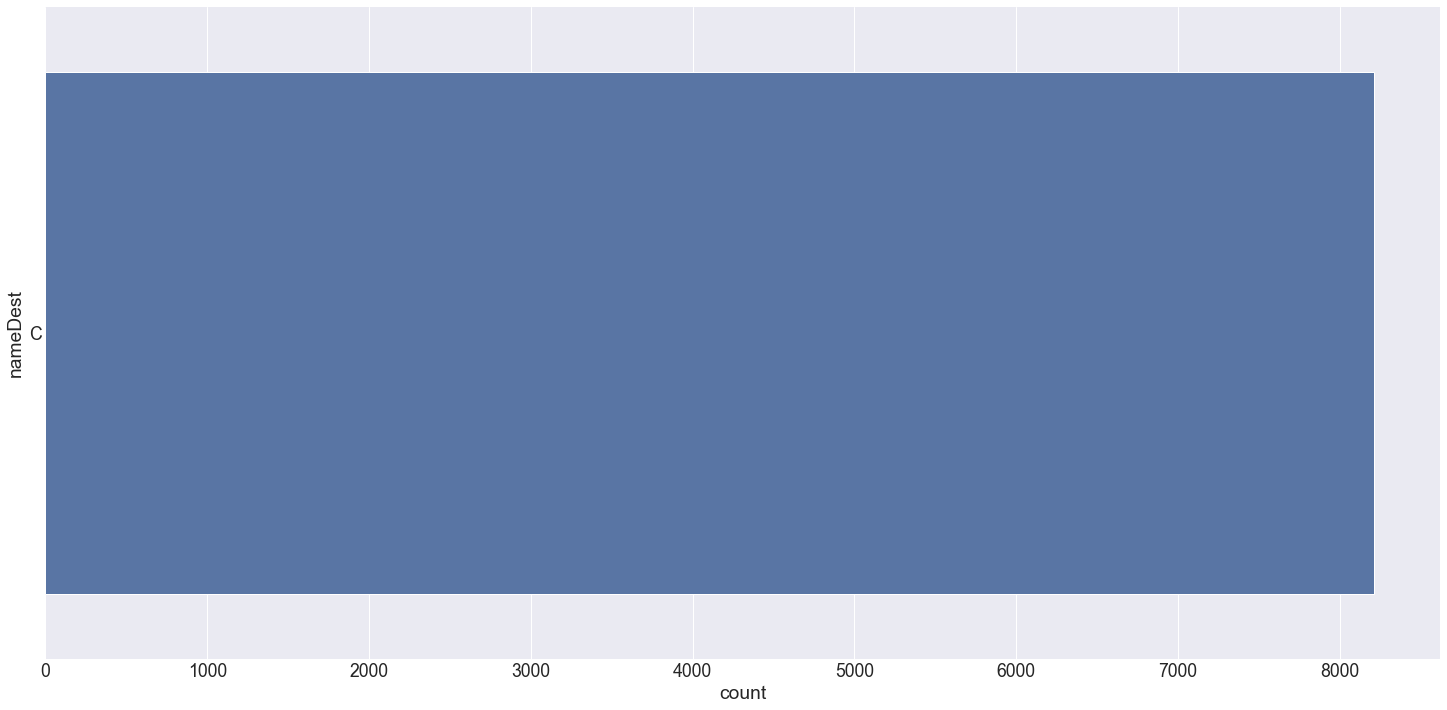

In [27]:
aux1 = df3[df3['isFraud'] == 'yes']
sns.countplot(y='nameDest', data=aux1)
np.unique(df3.nameOrig)

#### all fraud cases are either transfer or cashout

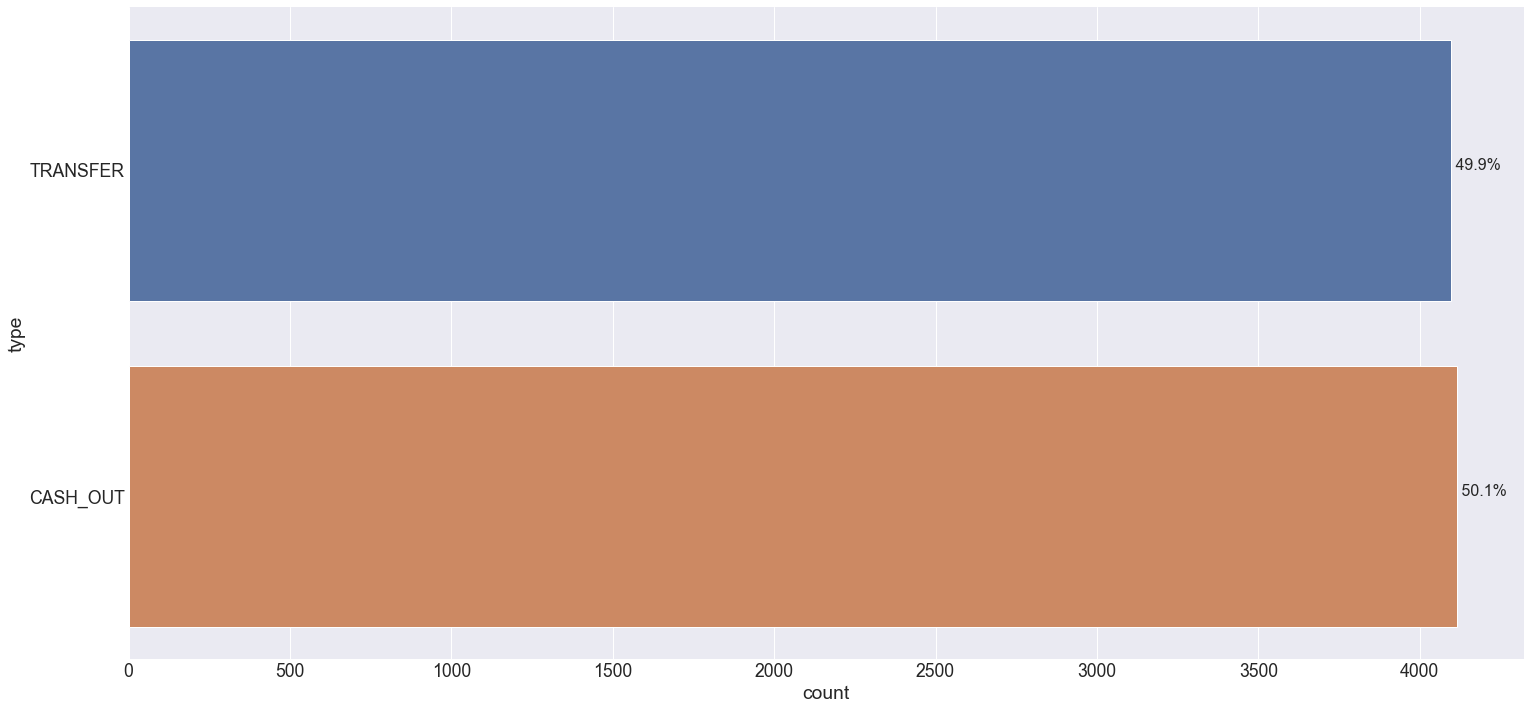

In [28]:
aux1 = df3[df3['isFraud'] == 'yes']
ax = sns.countplot(y='type', data=aux1)

total = aux1['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

#### H2 All the fraud amount is greater than 10.000.

#### Is there relation between number of days and amount of fraud

<AxesSubplot:xlabel='step_days', ylabel='amount'>

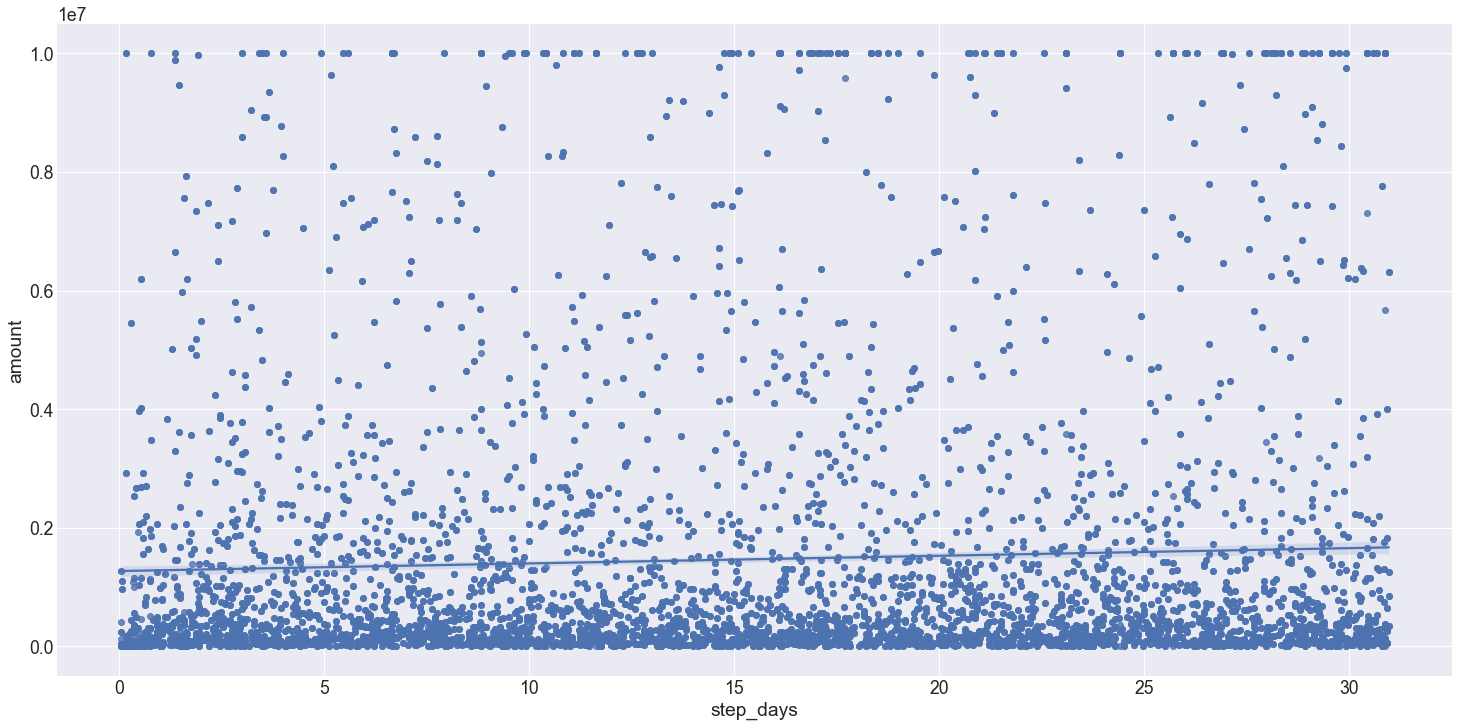

In [29]:
aux1 = df3[df3['isFraud'] == 'yes']
sns.regplot(x='step_days', y='amount', data=aux1)

#### relation bewtween amount and transfer type

In [30]:
# len(data.loc[data["type"]=="DEBIT"])
# print(np.unique(data.type))
np.sum(df3["amount"].values)

1144392944759.77

In [31]:
total =np.sum(df3["amount"].values)
for trans_type in np.unique(data.type):
    print( trans_type,len(data.loc[data["type"]==trans_type]) , np.sum(data.loc[data["type"]==trans_type, 'amount']), np.sum(data.loc[data["type"]==trans_type, 'amount']) / total)
# total = df3[df['type']==].size
# total

CASH_IN 1399284 236367391912.46002 0.20654390871142433
CASH_OUT 2237500 394412995224.4897 0.3446482233489167
DEBIT 41432 227199221.28 0.00019853252531864697
PAYMENT 2151495 28093371138.370007 0.024548710534271375
TRANSFER 532909 485291987263.1698 0.4240606248800685


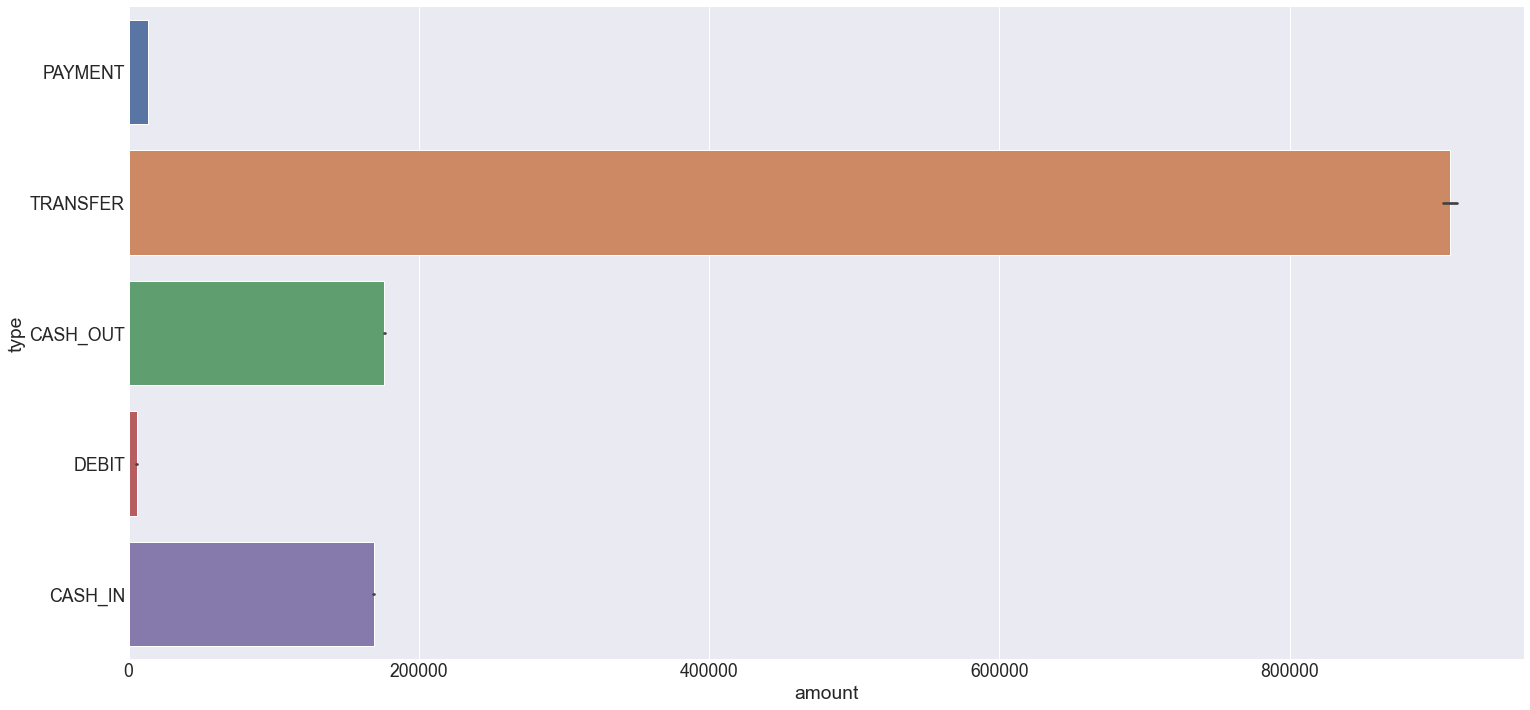

In [32]:
ax = sns.barplot(y='type', x='amount', data=df3)

# total = df3['type'].size
# # total = np.sum(df3["amount"].values)
# for p in ax.patches:
#         print(p)
#         percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
#         x = p.get_x() + p.get_width() + 0.02
#         y = p.get_y() + p.get_height()/2
#         ax.annotate(percentage, (x, y))

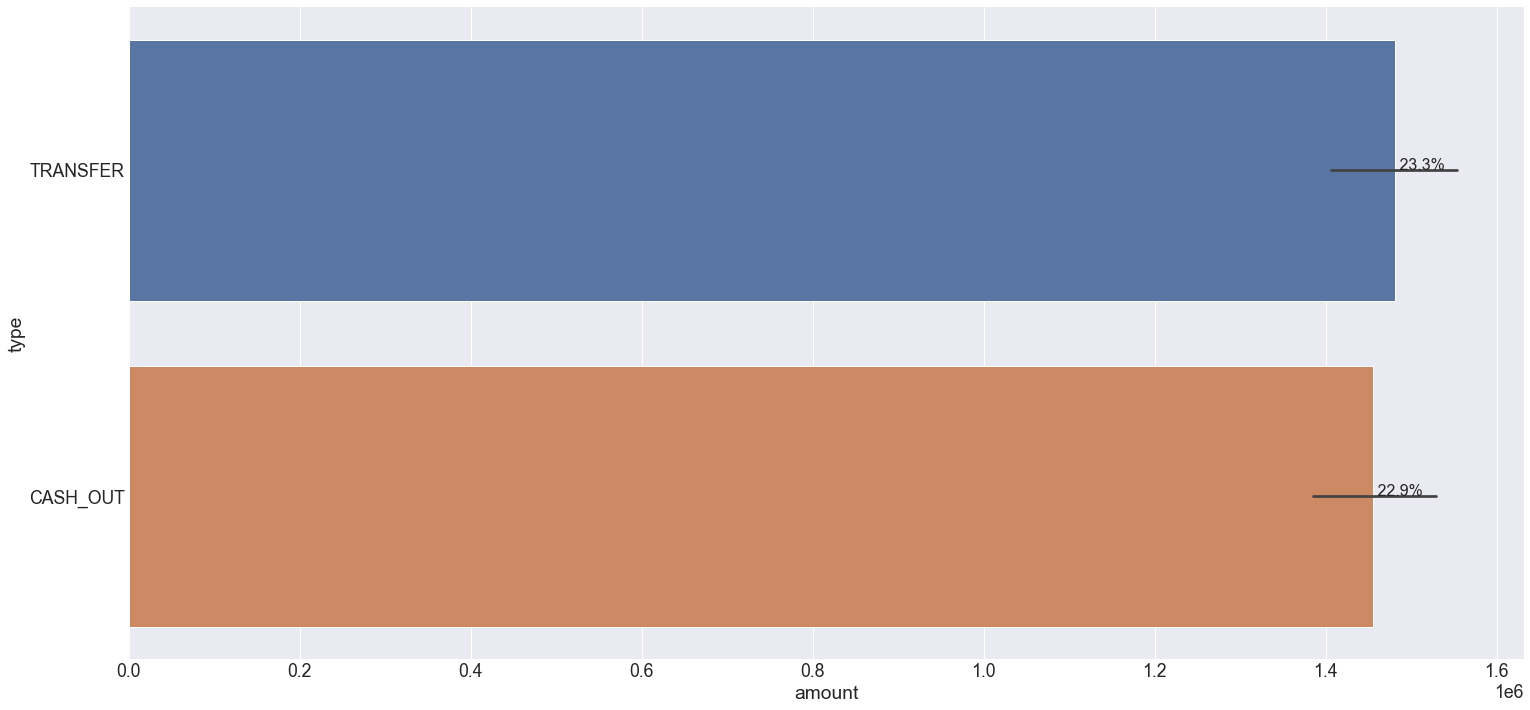

In [33]:
aux1 = df3[df3.isFraud=='yes']
ax = sns.barplot(y='type', x='amount', data=aux1)
total = df3['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### Collinearity analysis

#### Numerical variables

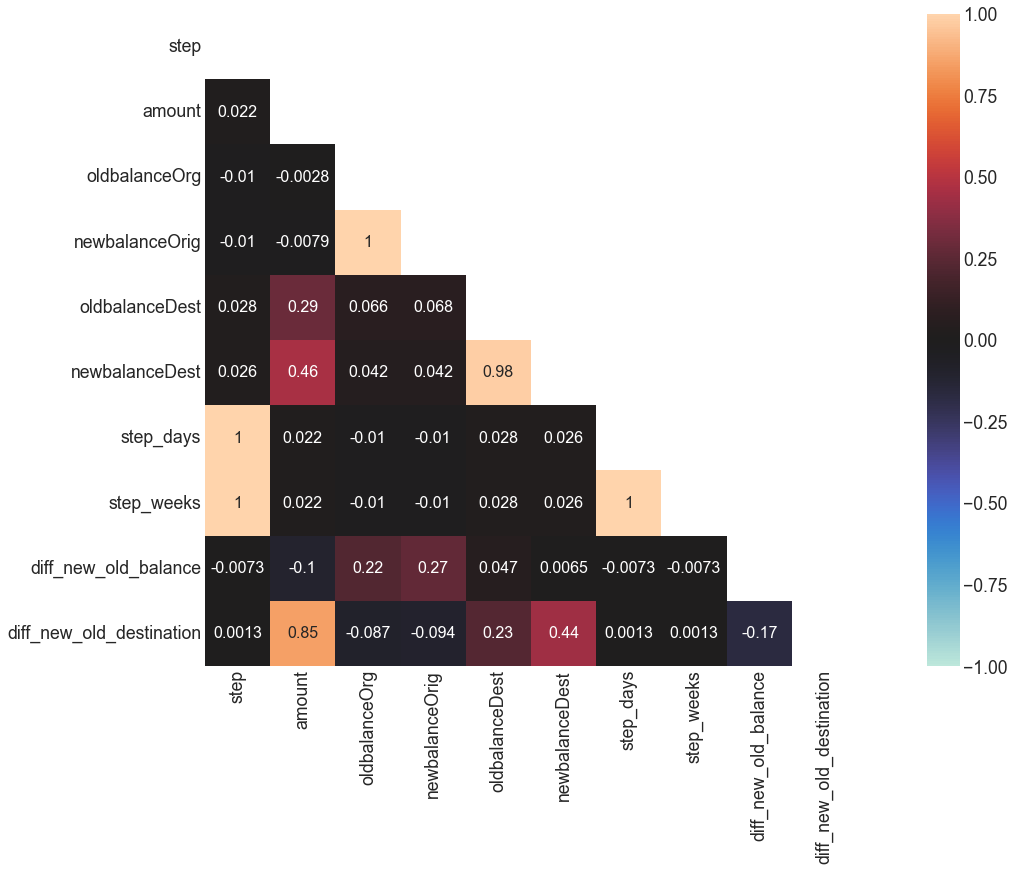

In [34]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

#### Categorical attributes

In [35]:
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}
    
    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])
        
corr = pd.DataFrame(dict_corr)

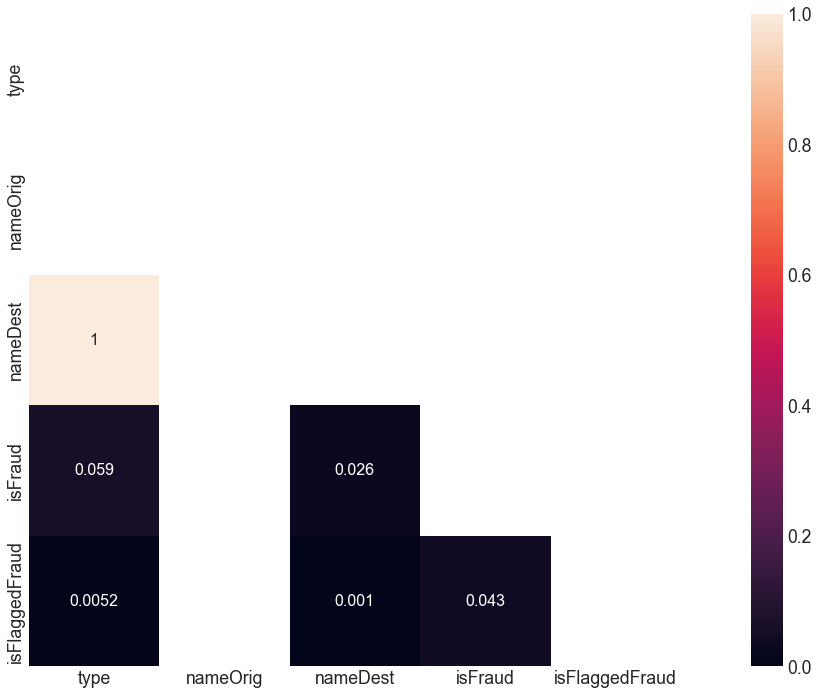

In [37]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

## Preparing Data for training model

In [39]:
df4 = df3.copy()

### train-test split

In [40]:
X = df4.drop(columns=['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest', 
                      'step_weeks', 'step_days'], axis=1)
y = df4['isFraud'].map({'yes': 1, 'no': 0})

In [42]:
df4.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'step_days', 'step_weeks', 'diff_new_old_balance',
       'diff_new_old_destination'],
      dtype='object')

In [44]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [45]:
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

### One-hot encoding

In [48]:
ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

### Rescaling


In [51]:
num_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
               'diff_new_old_balance', 'diff_new_old_destination']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

## Feature Selection

In [57]:
X_boruta = X_params.values
y_boruta = y_temp.values.ravel()

In [58]:
boruta = BorutaPy(RandomForestClassifier(), n_estimators='auto')
# boruta.fit(X_boruta, y_boruta)

KeyboardInterrupt: 

In [59]:
help(BorutaPy)

Help on class BorutaPy in module boruta.boruta_py:

class BorutaPy(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  BorutaPy(estimator, n_estimators=1000, perc=100, alpha=0.05, two_step=True, max_iter=100, random_state=None, verbose=0)
 |  
 |  Improved Python implementation of the Boruta R package.
 |  
 |  The improvements of this implementation include:
 |  - Faster run times:
 |      Thanks to scikit-learn's fast implementation of the ensemble methods.
 |  - Scikit-learn like interface:
 |      Use BorutaPy just like any other scikit learner: fit, fit_transform and
 |      transform are all implemented in a similar fashion.
 |  - Modularity:
 |      Any ensemble method could be used: random forest, extra trees
 |      classifier, even gradient boosted trees.
 |  - Two step correction:
 |      The original Boruta code corrects for multiple testing in an overly
 |      conservative way. In this implementation, the Benjamini Hochberg FDR is
 |      used to correct in eac

### Best Features

In [ ]:
# cols_selected_boruta = boruta.support_.tolist()

In [ ]:
# columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist()

In [ ]:
# columns_selected

In [62]:
final_columns_selected = ['step', 'oldbalanceOrg', 'newbalanceOrig',
                          'newbalanceDest', 
                          'diff_new_old_balance', 'diff_new_old_destination', 
                          'type_TRANSFER']
X_temp.columns

Index(['step', 'type_PAYMENT', 'type_CASH_OUT', 'type_CASH_IN',
       'type_TRANSFER', 'type_DEBIT', 'amount', 'oldbalanceOrg',
       'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
       'diff_new_old_balance', 'diff_new_old_destination'],
      dtype='object')

## Machine Learning model

In [63]:
X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]

X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

### Dummy baseline

In [68]:
dummy = DummyClassifier()
dummy.fit(X_train_cs, y_train)

y_pred = dummy.predict(X_valid_cs)

In [72]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5,0.0,0.0,0.0,0.0


In [73]:
## classification report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016706
           1       0.00      0.00      0.00      1314

    accuracy                           1.00   1018020
   macro avg       0.50      0.50      0.50   1018020
weighted avg       1.00      1.00      1.00   1018020



In [74]:
## cross validation
dummy_cv = ml_cv_results('Dummy', DummyClassifier(), X_temp, y_temp)
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


### Logistic Regression

In [75]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)

In [76]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.654,0.955,0.309,0.467,0.467


In [77]:
## classification report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016706
           1       0.96      0.31      0.47      1314

    accuracy                           1.00   1018020
   macro avg       0.98      0.65      0.73   1018020
weighted avg       1.00      1.00      1.00   1018020



In [78]:
## cross validation
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(), 
                      X_temp_cs, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.656 +/- 0.007,0.956 +/- 0.009,0.312 +/- 0.013,0.47 +/- 0.015,0.469 +/- 0.015


### K-nearest neighbours


In [79]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_valid_cs)

In [80]:
knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.796,0.949,0.593,0.73,0.729


In [81]:
## classification report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016706
           1       0.95      0.59      0.73      1314

    accuracy                           1.00   1018020
   macro avg       0.97      0.80      0.86   1018020
weighted avg       1.00      1.00      1.00   1018020



In [82]:
## cross validation
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(), 
                       X_temp_cs, y_temp)
knn_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.797 +/- 0.005,0.949 +/- 0.011,0.595 +/- 0.01,0.731 +/- 0.01,0.731 +/- 0.01


### SVM

In [83]:
svm = SVC()
svm.fit(X_train_cs, y_train)

y_pred = svm.predict(X_valid_cs)

In [84]:

svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.651,0.997,0.302,0.464,0.463


In [85]:
## classificatipn report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016706
           1       1.00      0.30      0.46      1314

    accuracy                           1.00   1018020
   macro avg       1.00      0.65      0.73   1018020
weighted avg       1.00      1.00      1.00   1018020



In [86]:
## cross validation
svm_cv = ml_cv_results('SVM', SVC(), X_temp_cs, y_temp)
svm_cv

Fold K=1


### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)

In [ ]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

In [ ]:
## classification report
print(classification_report(y_valid, y_pred))

In [ ]:
## cross validation
rf_cv = ml_cv_results('Random Forest', 
                      RandomForestClassifier(), 
                      X_temp_cs, y_temp)
rf_cv

### XGBoost 

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)

In [ ]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

In [ ]:
## classification report
print(classification_report(y_valid, y_pred))

In [ ]:
## cross validation
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(),
                       X_temp_cs, y_temp)
xgb_cv

### Comparing Model's Performance

In [ ]:
## single performance
modeling_performance = pd.concat([dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, svm_results])
modeling_performance.sort_values(by="F1", ascending=True)

In [ ]:
## cross validation performnace
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv,  
                                     rf_cv, xgb_cv, svm_cv])

modeling_performance_cv.sort_values(by="F1", ascending=True)

## Hyperparameter Fine Tuning

In [ ]:
f1 = make_scorer(f1_score)

In [ ]:
params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.3, 0.1, 0.01],
    'scale_pos_weight': [1, 774, 508, 99]
}

In [ ]:
gs = GridSearchCV(XGBClassifier(), 
                  param_grid=params, 
                  scoring=f1, 
                  cv=StratifiedKFold(n_splits=5))

gs.fit(X_params_cs, y_temp)

In [ ]:
best_params = gs.best_params_
best_params

In [ ]:
best_params = {'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

In [ ]:
gs.best_score_

### results


In [ ]:
xgb_gs = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

In [ ]:
xgb_gs.fit(X_train_cs, y_train)

In [ ]:
y_pred = xgb_gs.predict(X_valid_cs)

In [ ]:
xgb_gs_results = ml_scores('XGBoost GS', y_valid, y_pred)
xgb_gs_results

In [ ]:
## cross validation
xgb_gs_cv = ml_cv_results('XGBoost GS', xgb_gs, X_temp_cs, y_temp)
xgb_gs_cv

## Conclusions

### final model

In [ ]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_cs, y_temp)

In [ ]:
## predict unseen data
y_pred = final_model.predict(X_test_cs)

In [ ]:
unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores